In [1]:
from glob import glob
import json
import re
import wikitextparser as wtp
import flair
import numpy as np
import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from datetime import datetime
import networkx as nx
import ciso8601
import seaborn as sns
import pandas as pd
import config
import nltk
from collections import defaultdict
import pickle
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
sns.set()

In [2]:
vader_sentiment = SentimentIntensityAnalyzer()
flair_sentiment = flair.models.TextClassifier.load('en-sentiment')

2021-12-05 23:26:14,126 loading file C:\Users\lucas\.flair\models\sentiment-en-mix-distillbert_4.pt


# Part 1 - Wowhead comments

In [3]:
for fn in tqdm(glob('data/char_comments/*.njson')[:1]):
    comments = [json.loads(l) for l in open(fn, 'r', encoding='utf-8')]
    comments = sum(map(
        lambda c: [c] + c.get('replies', []),
        comments
    ), [])
    
    for comment in comments:
        # print("%s" % comment.get('body'))
        if ('\n' in comment['body']):
            print(repr(comment['body']))

  0%|          | 0/1 [00:00<?, ?it/s]

"He won't give you the Trial of the Naaru quests until you've completed the [url=http://www.wowhead.com/?quest=10588]Cipher of Damnation[/url] quest in Shadowmoon.\n\nLikewise, you won't get the quest for getting the Arcatrz key util you do the quest chain that starts with [url=http://www.wowhead.com/?quest=10264]Assisting the Consortium[/url]."
"Lol, this dude has 7300 health. I once saw Uvuros from Shadowmoon Valley in Shattrath and he killed A'dal in 3 attacks.\r\n\r\nSome all powerful being. Rofl"
"Ok so enslaved a demon from Shadowmoon and ran to adal, once he cleaved me for 1k and rain of fired us, A'dal lived and one shot him, so yea...that was fun.\r\n(BTW this is on PTR)"
'Ok me and a few guildys kited a few fel reavers and some fel soldiers over to this guy and damn he hits hard.\r\n\r\n114k he hit normal, non crit on a fel reaver.\r\n\r\nWRATH guild members included in the pull.\r\n\r\nStillman - Tankadin\r\nSipilidin-  Healadin\r\nDragoona- Rogue- Clear mobs along the way\r

In [4]:
char_sentiments = defaultdict(list)

seen_ids = {}
for fn in tqdm(glob('data/char_comments/*.njson')):
    char_name = os.path.basename(fn)[:-6].replace('_', ' ')

    comments = [json.loads(l) for l in open(fn, 'r', encoding='utf-8')]
    comments = sum(map(
        lambda c: [c] + c.get('replies', []),
        comments
    ), [])

    for comment in comments:
        text = comment.get('body', '')
        text = re.sub(r"\[.+?\]", "", text)
        # text = re.sub(r"[\t\n\r]+", " ", text)
        text = re.sub(r"(\\r|\\n|\\t)+", " ", text)
        
        # vader sentiment
        sentences = re.findall(r"(.+?(?:[!.?]+|$))(?:\s|$)", text)
        
        vader_score = np.mean(
            [vader_sentiment.polarity_scores(sentence.strip())['compound'] for sentence in sentences] or [0]
        )

        # bert sentiment
        s = flair.data.Sentence(text)
        flair_sentiment.predict(s)
        if len(s.labels) < 1:
            continue
        label = s.labels[0]
        bert_score = (label.score-0.5)*2
        sign = 1 if label.value == 'POSITIVE' else -1
        bert_score *= sign
        char_sentiments[char_name].append(
            (comment['id'], vader_score, bert_score)
        )
        

with open('char_sentiments.pkl', 'wb') as f:
    pickle.dump(dict(char_sentiments), f)

  0%|          | 0/241 [00:00<?, ?it/s]

2021-12-05 23:27:19,381 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2021-12-05 23:27:55,191 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2021-12-05 23:28:02,952 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2021-12-05 23:29:27,955 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2021-12-05 23:29:34,057 Warning: An empty Sentence was created! Are there empty strings in your dataset?


In [5]:
char_comments = {
    os.path.basename(fn)[:-6].replace('_', ' '): [json.loads(l) for l in open(fn, 'r', encoding='utf-8')]
    for fn in glob('data/char_comments/*.njson')
}

def standardize_comment(comment):
    return {
        'id': comment['id'],
        'body': comment['body'],
        'user': comment.get('user', comment.get('username')),
        'date': comment.get('date', comment.get('creationdate')),
        'rating': comment['rating'],
        'is_reply': comment.get('nreplies', 0) > 0
    }

# unpack replies from comments and resolve common keys
for char in char_comments:
    char_comments[char] = sum(map(
        lambda c: [standardize_comment(c)] + [standardize_comment(r) for r in c.get('replies', [])],
        char_comments[char]
    ), [])


char_sentiments = pickle.load(open('char_sentiments.pkl', 'rb'))
char_data = defaultdict(dict)
for char,comments in char_sentiments.items():
    for comment_id,vader_score,bert_score in comments:
        comment = next(c for c in char_comments[char] if c['id'] == comment_id)
        char_data[char][comment_id] = {
            'date': ciso8601.parse_datetime_as_naive(comment['date']),
            'rating': comment['rating'],
            'vader_sentiment': vader_score,
            'bert_sentiment': bert_score,
            'is_reply': comment['is_reply']
        }

In [6]:
Gcc = nx.read_gexf(config.PATH_RES + 'Gcc_wow.gexf').to_undirected()
# load communities
communities = pickle.load(open(config.PATH_RES + 'Communities.json', 'rb'))

# get top chars in each community
degs = list(Gcc.degree())
com_names = []
for com in communities:
    com_sorted = sorted([(n, v) for n, v in degs if n in com], key=lambda x: x[1], reverse=True)
    top_names = [n for n, _ in com_sorted[:3]]
    com_name = ', '.join(top_names)
    com_names.append(com_name)
    
breakdown_lookup = {
    'faction': ('Faction', ['Horde', 'Alliance', 'Neutral']),
    'gender': ('Gender', ['Male', 'Female']),
    'status': ('Status', ['Alive', 'Deceased']),
    'community': ('Community', com_names)    
}

In [7]:
# read in character DataFrame
df = pd.read_csv(config.PATH_RES + 'df_chars.csv')
df = df[df.Name.apply(lambda n: n in char_sentiments)]
df = df[df.Name.apply(lambda n: n in Gcc)]
df.Faction = df.Faction.apply(lambda f: f if f in ['Horde', 'Alliance'] else 'Neutral')
df['Community'] = df.Name.apply(lambda n: com_names[next(i for i,C in enumerate(communities) if n in C)])
df.head()

,Name,Gender,Race,Faction,Status,Community
0,A'dal,Unknown,Naaru,Neutral,Alive,"Khadgar, Illidan Stormrage, Lor'themar Theron"
2,Aegwynn,Female,Human,Neutral,Deceased,"Thrall, Ner'zhul, Orgrim Doomhammer"
3,Aessina,Female,Wisp,Neutral,Unknown,"Tyrande Whisperwind, Malfurion Stormrage, Alex..."
4,Aethas Sunreaver,Male,Blood Elf,Horde,Alive,"Khadgar, Illidan Stormrage, Lor'themar Theron"
5,Agamaggan,Male,Boar,Neutral,Deceased,"Tyrande Whisperwind, Malfurion Stormrage, Alex..."


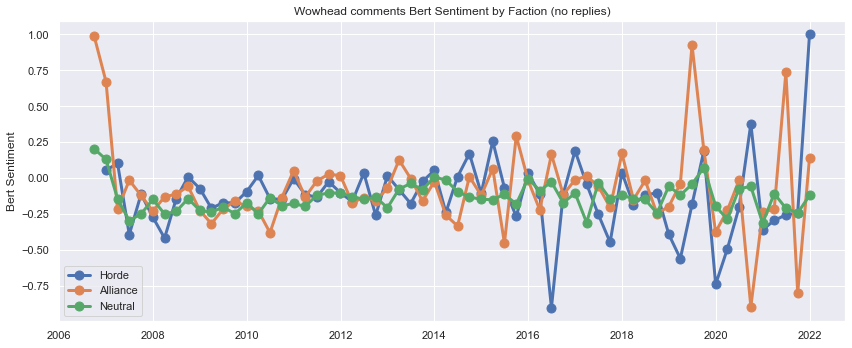

In [8]:
P = {
    'breakdown': 'faction', # ['faction', 'gender', 'status', 'community'],
    'metric': 'bert_sentiment', # ['bert_sentiment', 'vader_sentiment', 'rating'],
    'resample': 'Q', # ['M', 'Q', 'Y']
    'replies': False, # [True, False]
}

def plot_timeseries(params, counts=False):
    plt.figure(figsize=(12,5))
    k,grps = breakdown_lookup[params['breakdown']]
    for val in grps:
        grp_chars = list(df[df[k] == val].Name)

        points = []
        for char in grp_chars:
            for C in char_sentiments[char]:
                comment_id = C[0]
                data = char_data[char][comment_id]
                if params['replies'] and not data['is_reply']:
                    continue
                points.append({
                    'date': data['date'],
                    'score': data[params['metric']]
                })
        d = pd.DataFrame(points)
        d = d[d.date > datetime(2006,6,1)]
        d = d[d.date < datetime(2021,11,1)]
        d = d.resample(params['resample'], on='date')
        x = list(d.indices)
        if counts:
            y = d.score.count().dropna()
            plt.title(
                'Wowhead comments count by %s (%sreplies)' % (
                    k,
                    'no ' if not params['replies'] else ''
                )
            )
            figpath = f'{config.PATH_PLOTS}ts-counts.png'
        else:
            y = d.score.mean().dropna()
            plt.title(
                'Wowhead comments %s by %s (%sreplies)' % (
                    params['metric'].title().replace('_', ' '),
                    k,
                    'no ' if not params['replies'] else ''
                )
            )
            figpath = f'{config.PATH_PLOTS}ts-example.png'
        plt.plot(x, y, 'o-', ms=9, linewidth=3, label=val)
    plt.ylabel(params['metric'].title().replace('_', ' '))
    plt.legend()
    plt.tight_layout()
    plt.savefig(figpath)
    plt.show()

plot_timeseries(P)

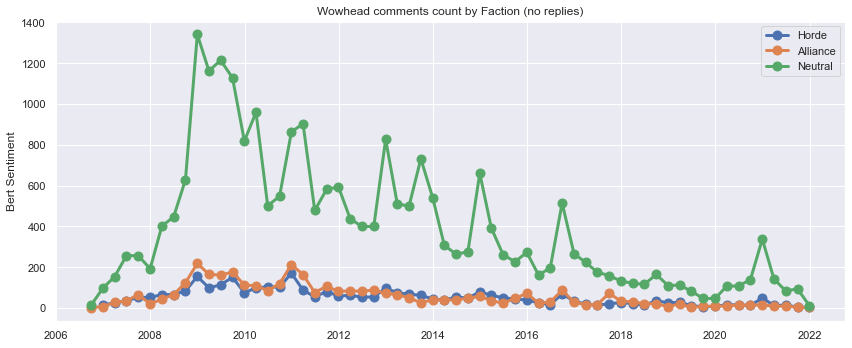

In [9]:
plot_timeseries(P, counts=True)

In [10]:
param_grid = {
    'breakdown': ['faction', 'gender', 'status', 'community'],
    'metric': ['bert_sentiment', 'vader_sentiment', 'rating'],
    'resample': ['M', 'Q', 'Y'],
    'replies': [True, False]
}

dataset = []
for p_breakdown in param_grid['breakdown']:
    for p_metric in param_grid['metric']:
        for p_resample in param_grid['resample']:
            for p_replies in param_grid['replies']:
                params = {
                    'breakdown': p_breakdown,
                    'metric': p_metric,
                    'resample': p_resample,
                    'replies': p_replies
                }
                k,grps = breakdown_lookup[params['breakdown']]
                for val in grps:
                    grp_chars = list(df[df[k] == val].Name)
                    points = []
                    for char in grp_chars:
                        for C in char_sentiments[char]:
                            comment_id = C[0]
                            data = char_data[char][comment_id]
                            if params['replies'] and not data['is_reply']:
                                continue
                            points.append({
                                'date': data['date'],
                                'score': data[params['metric']]
                            })
                    d = pd.DataFrame(points)
                    d = d[d.date > datetime(2006,6,1)]
                    d = d[d.date < datetime(2021,11,1)]
                    d = d.resample(params['resample'], on='date')
                    x = [dt.to_pydatetime().strftime('%Y-%m-%d 00:00:00') for dt in list(d.indices)]
                    y = list(d.score.mean().dropna().values)
                    dataset.append({**params, **dict(x=x, y=y, label=val)})
                
open('visualizations/comment-sentiments-ts.json', 'w').write(json.dumps(dataset))

863375

 # Part 2 - Wiki quotes

In [19]:
quote_sentiments = []
for fn in tqdm(glob('data/wow_chars_quotes/*.txt')):
    char_name = os.path.basename(fn).replace('.txt', '').replace('_', ' ')
    char_quotes = open(fn, 'r', encoding='utf-8').readlines()
    
    for text in char_quotes:
        text = re.sub(r"\[.+?\]", "", text)
        text = re.sub(r"[\t\n\r]+", " ", text)

        # vader sentiment
        sentences = re.findall("(.*?[.!]+)[\s$]", text)

        vader_score = np.mean(
            [vader_sentiment.polarity_scores(sentence.strip())['compound'] for sentence in sentences] or [0]
        )

        # bert sentiment
        s = flair.data.Sentence(text)
        flair_sentiment.predict(s)
        if len(s.labels) < 1:
            continue
        label = s.labels[0]
        sign = 1 if label.value == 'POSITIVE' else -1
        bert_score = sign*label.score

        quote_sentiments.append({
            'char': char_name,
            'text': text,
            'bert_sentiment': bert_score,
            'vader_sentiment': vader_score
        })

qs = pd.merge(
    pd.DataFrame(quote_sentiments).groupby('char').mean().reset_index(),
    df,
    left_on='char',
    right_on='Name',
    how='inner'
).drop('char', axis=1)

  0%|          | 0/223 [00:00<?, ?it/s]

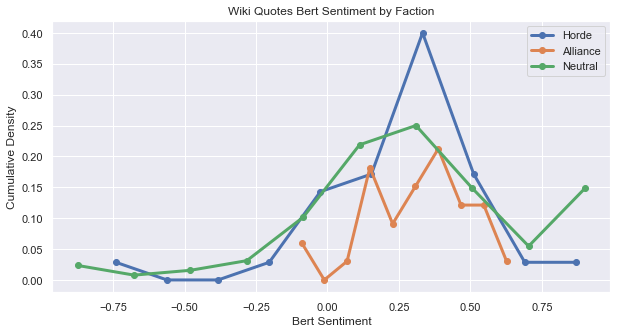

In [20]:
def plot_quote_dist(params):
    plt.figure(figsize=(10,5))
    k,grps = breakdown_lookup[params['breakdown']]

    for val in grps:
        counts,bins = np.histogram(qs[qs[k] == val][params['metric']], density=True)
        x = 0.5 * (bins[1:] + bins[:-1])
        y = counts/counts.sum()
        plt.plot(x, y, 'o-', label=val, linewidth=3)

    plt.title('Wiki Quotes %s by %s' % (params['metric'].title().replace('_', ' '), k))
    plt.legend()
    plt.xlabel('%s' % params['metric'].title().replace('_', ' '))
    plt.ylabel('Cumulative Density')
    plt.show()
    
plot_quote_dist({
    'breakdown': 'faction',    # ['faction', 'gender', 'status', 'community'],
    'metric': 'bert_sentiment' # ['bert_sentiment', 'vader_sentiment'],
})

In [21]:
dataset = []
for p_breakdown in param_grid['breakdown']:
    for p_metric in param_grid['metric']:
        if p_metric == 'rating':
            continue
        params = {
            'breakdown': p_breakdown,
            'metric': p_metric
        }
        k,grps = breakdown_lookup[params['breakdown']]

        for val in grps:
            counts,bins = np.histogram(qs[qs[k] == val][params['metric']], density=True)
            x = list(0.5 * (bins[1:] + bins[:-1]))
            y = list(counts/counts.sum())
            dataset.append({**params, **dict(x=x, y=y, label=val)})
        
open('visualizations/wiki-sentiments-dist.json', 'w').write(json.dumps(dataset))

13591

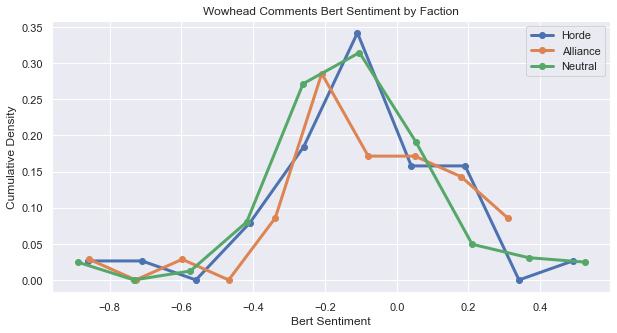

In [22]:
cs = pd.DataFrame.from_records(
    df.apply(
        lambda x: {
            **dict(x),
            **{ k: np.mean([v[k] for v in char_data[x.Name].values()]) for k in ['bert_sentiment', 'vader_sentiment'] },
        },
        axis=1
    )
)

def plot_comments_dist(params):
    plt.figure(figsize=(10,5))
    k,grps = breakdown_lookup[params['breakdown']]

    for val in grps:
        counts,bins = np.histogram(cs[cs[k] == val][params['metric']], density=True)
        x = 0.5 * (bins[1:] + bins[:-1])
        y = counts/counts.sum()
        plt.plot(x, y, 'o-', label=val, linewidth=3)

    plt.title('Wowhead Comments %s by %s' % (params['metric'].title().replace('_', ' '), k))
    plt.legend()
    plt.xlabel('%s' % params['metric'].title().replace('_', ' '))
    plt.ylabel('Cumulative Density')
    plt.show()
    
plot_comments_dist({
    'breakdown': 'faction',    # ['faction', 'gender', 'status', 'community'],
    'metric': 'bert_sentiment' # ['bert_sentiment', 'vader_sentiment'],
})

In [23]:
dataset = []
for p_breakdown in param_grid['breakdown']:
    for p_metric in param_grid['metric']:
        if p_metric == 'rating':
            continue
        params = {
            'breakdown': p_breakdown,
            'metric': p_metric
        }
        k,grps = breakdown_lookup[params['breakdown']]

        for val in grps:
            counts,bins = np.histogram(cs[cs[k] == val][params['metric']], density=True)
            x = list(0.5 * (bins[1:] + bins[:-1]))
            y = list(counts/counts.sum())
            dataset.append({**params, **dict(x=x, y=y, label=val)})
        
open('visualizations/comments-sentiments-dist.json', 'w').write(json.dumps(dataset))

13981

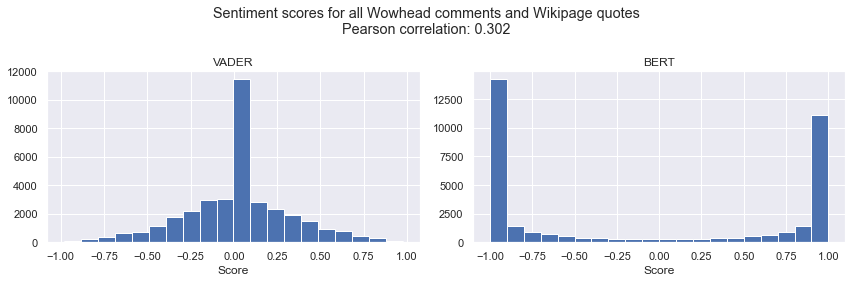

In [24]:
R = df.apply(
    lambda x: 
    [[v[k] for v in char_data[x.Name].values()] for k in ['bert_sentiment', 'vader_sentiment']],
    axis=1
)
b = []
v = []
for r in R:
    b += r[0]
    v += r[1]
b += [q['bert_sentiment'] for q in quote_sentiments]
v += [q['vader_sentiment'] for q in quote_sentiments]


fig,ax = plt.subplots(1,2)
fig.set_size_inches(12,4)

ax[0].hist(v, bins=20)
ax[0].set_title('VADER')
ax[0].set_xlabel('Score')
ax[1].hist(b, bins=20)
ax[1].set_title('BERT')
ax[1].set_xlabel('Score')

corr = np.corrcoef([b,v])[0,1]
plt.suptitle('Sentiment scores for all Wowhead comments and Wikipage quotes\nPearson correlation: %.3f' % corr)
plt.tight_layout()
plt.savefig(f'{config.PATH_PLOTS}sentdist.png')
plt.show()

In [17]:
import random

def get_specific_comment(k, t):
    for char_name,comment_data in random.sample(char_data.items(), len(char_data)):
        for comment_id, cd in comment_data.items():
            if cd[k] > t:
                comment = next(cc for cc in char_comments[char_name] if cc['id'] == comment_id)
                return cd['bert_sentiment'], cd['vader_sentiment'], comment['body']
            
for _ in range(5):
    print('bert %.2f, vader %.2f - %s' % get_specific_comment('bert_sentiment', 0.75))
    print()


bert 1.00, vader 0.33 - o m g, this npc looks awesome! Can't wait to see her in-game :D.

bert 0.94, vader -0.58 - The Tidestone appears on the dias after [npc=115767] is defeated. Final boss of Tomb's LFR Wing 1 (The Gates of Hell).

bert 0.99, vader 0.00 - [b]And they say Blizzard games don't have bugs.[/b]

bert 0.97, vader -0.17 - She can be found in the Chamber of the Moon (Tomb of Sargeras). She stands in front of 4 pedestals. Currently in Gates of Hell LFR, I see the 'The Aegis of Aggramar' & 'The Tidestone of Golganneth' on the pedestals.

She has 207,853,408 health.

bert 1.00, vader 0.42 - He's a real g, lol

